In [1]:
import glob, os, sys
# sys.path.append("..")
# from utils.utils import *
import uproot, time, vector
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import json
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier 
import pickle

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

In [2]:
Ztt_inc = [
    700792, 700793, 700794,
    700901, 700902, 700903,
    ]
# ttV = [
#     522024, 522028, 522032, 522036, 522040, 700995, 700996, 700997    
#     ]
# Diboson
VV = [
    #701040, 701045, 701050, 701055, 701060, 701065, 
    701085, 701095, 701105, 701110, 701115, 701125 
]
# Single-Top and ttbar (new samples now!)
Top = [
    601229, 601230, 601237, 601348, 601349, 601350, 601351, 601352, 601355,
]
# W(tau/mu/e + nu) + jets
W = [
    700777, 700778, 700779, # Wenu
    700780, 700781, 700782, # Wmunu #! 700342 is missing (should be okay... basically no W)
    700783, 700784, 700785,
]
Zll_inc = [
   700786, 700787, 700788, 700895, 700896, 700897,
   700789, 700790, 700791, 700898, 700899, 700900
]
# Signal samples (new)
ggH = [
    # mc23 DSIDs
    603414, 603415, 603416, 603417,
    603418 # ggHWW
    ]
VBFH = [
    # mc20 DSIDs
    603422, 603423, 603424, 603425,
]
WH = [603426, 603427]
# ZH = [603428]
ttH = [603419,603420,603421]

LUMI = {
    '22': 26071.4,
    '23': 25767.5,
    '24': 109758.0,
}

LUMI_SCALE = {
    '22': 1,
    '23': 1,
    '24': 1,
}

In [3]:
def read_event_weights(event_id, data_year):
    file_path = './xsec_sumofweights_nom_run3.json'
    # Load the data from the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Get the list of events from the key 'ditau_hh' under 'mc20a'
    events = data.get(data_year, {}).get('ditau_hh', [])
    # Iterate over each event in the list
    for event in events:
        # Check if the first element (ID) matches the provided event_id
        if event[0] == event_id:
            # Return the second (event weight) and third (sum of event weights) elements
            return (event[1], event[2])
    # If no matching ID is found, return None for both values
    return (None, None)

def fetch_weights(id_list, data_year):
    results = {}
    for event_id in id_list:
        event_weight, sum_event_weights = read_event_weights(event_id, data_year)
        if event_weight is None:
            print(event_id, "weights filled with one")
            results[event_id] = 1
        else: 
            print(event_id, "year: ", data_year, "weight: ", event_weight, "sum: ", sum_event_weights)
            results[event_id] = event_weight / sum_event_weights
    return results


In [4]:
# Define datasets and processes
datasets = ['mc23a', 'mc23d']

categories = {
    'signal': {
        'VBFH': VBFH, 'ggH': ggH, 'WH': WH, 'ttH': ttH, 
    },
    'background': {
        'Ztt_inc': Ztt_inc, 'VV': VV, 'Top': Top, 
        'W': W, 'Zll_inc': Zll_inc
    }
}

# Initialize a dictionary to store weights
weights = {}

# Fetch weights for each dataset and category
for dataset in datasets:
    weights[dataset] = {}
    for category, processes in categories.items():
        weights[dataset][category] = {}
        for process_name, process_list in processes.items():
            key = f"{process_name}_ws_{dataset[-1]}"
            weights[dataset][category][key] = fetch_weights(process_list, dataset)

weights

603422 year:  mc23a weight:  0.05048950954 sum:  50058121.76775932
603423 year:  mc23a weight:  0.01739184846 sum:  24941449.973656654
603424 year:  mc23a weight:  0.020462623080000002 sum:  24985585.3717494
603425 year:  mc23a weight:  0.01476969442 sum:  49760343.502305984
603414 year:  mc23a weight:  0.61191944 sum:  120279034.66296768
603415 year:  mc23a weight:  0.24496432399999998 sum:  43797256.747989655
603416 year:  mc23a weight:  0.24483329199999998 sum:  43492981.60149193
603417 year:  mc23a weight:  0.174076012 sum:  110419497.68087769
603418 year:  mc23a weight:  0.0085 sum:  18553.604413885623
603426 year:  mc23a weight:  0.035606 sum:  1124741.6219133735
603427 year:  mc23a weight:  0.055752 sum:  1795995.028975904
603419 year:  mc23a weight:  0.25502 sum:  502361.5603804904
603420 year:  mc23a weight:  0.058901999999999996 sum:  115444.3536548052
603421 year:  mc23a weight:  0.24496977535800005 sum:  620564.5666933622
700792 year:  mc23a weight:  55.58360685688 sum:  50

{'mc23a': {'signal': {'VBFH_ws_a': {603422: 1.0086177378816182e-09,
    603423: 6.973070322041983e-10,
    603424: 8.189771332368541e-10,
    603425: 2.968165687866593e-10},
   'ggH_ws_a': {603414: 5.08749876247886e-09,
    603415: 5.593143091347705e-09,
    603416: 5.629259779044477e-09,
    603417: 1.5764970467724405e-09,
    603418: 4.581320055330355e-07},
   'WH_ws_a': {603426: 3.1657048433424415e-08, 603427: 3.104240217846839e-08},
   'ttH_ws_a': {603419: 5.07642343906343e-07,
    603420: 5.102198430260629e-07,
    603421: 3.947530821221481e-07}},
  'background': {'Ztt_inc_ws_a': {700792: 1.0977432588215583e-12,
    700793: 1.4635013326152238e-12,
    700794: 9.377032924504746e-13,
    700901: 5.882924081020693e-12,
    700902: 5.086463383496978e-12,
    700903: 5.571640934369776e-12},
   'VV_ws_a': {701085: 2.822775096242424e-12,
    701095: 4.912740084998563e-12,
    701105: 9.869139453009272e-12,
    701110: 8.664257777194848e-12,
    701115: 1.0680142256185153e-11,
    701125:

In [5]:
branches = \
[
'ditau_obj_truth_leadTau_p4',
'ditau_obj_truth_subleadTau_p4',
'boson_0_classifierParticleOrigin',
'boson_0_mother_pdgId',
'boson_0_mother_status',
'boson_0_pdgId',
'boson_0_truth_pdgId',
'boson_0_truth_q',
'boson_0_truth_status',
'boson_0_q',
'ditau_obj_IsTruthMatched',
'ditau_obj_IsTruthHadronic',
'ditau_obj_truth_p4',
'met_truth_p4',
'NOMINAL_pileup_random_run_number',
'ditau_obj_bdt_score',
'ditau_obj_omni_score',
'ditau_obj_leadsubjet_charge',
'ditau_obj_leadsubjet_n_core_tracks',
'ditau_obj_leadsubjet_p4',
'ditau_obj_nSubjets',
'ditau_obj_n_tracks',
'ditau_obj_p4',
'ditau_obj_subleadsubjet_charge',
'ditau_obj_subleadsubjet_n_core_tracks',
'ditau_obj_subleadsubjet_p4',
'jets_p4',
'event_number',
'met_p4',
'met_sumet',
'met_hpto_p4',
'event_is_bad_batman',
'NOMINAL_pileup_combined_weight',
'n_bjets_DL1dv01_FixedCutBEff_70',
'weight_mc']

data_branches = \
[
 'event_number',    
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'event_is_bad_batman',
 'ditau_obj_bdt_score',
 'ditau_obj_omni_score',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
 'jets_p4',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'n_bjets_DL1dv01_FixedCutBEff_70']

In [6]:
path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/new_T01/T01/mc/ditau_hh/{year}/nom/user.*.{dsid}.*/user.*.root'

def read_root(dsid_list, mc_ws, year_id='mc20e', year='18'):
    out = []
    hlt_branches = {
        '22': ['HLT_j420_pf_ftf_preselj225_L1J100', 'HLT_j420_35smcINF_a10t_lcw_jes_L1J100'],
        '23': ['HLT_j420_pf_ftf_preselj225_L1J100', 'HLT_j420_35smcINF_a10t_lcw_jes_L1J100'],
        '24': ['HLT_j400_pf_ftf_preselj225_L1jJ180']
    }
    
    for dsid in dsid_list:
        # Using wildcard pattern around the DSID
        file_pattern = path_template.format(dsid=dsid, year=year_id)
        files = glob.glob(file_pattern)
        s = time.time()
        
        for file in files:
            with uproot.open(file + ':NOMINAL') as f_1:
                branches_read = branches + hlt_branches.get(year, [])
                events = f_1.arrays(branches_read, library='ak')
                events['weight'] = (mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks'])) * \
                                    events['weight_mc'] * events['NOMINAL_pileup_combined_weight'] * \
                                    LUMI_SCALE[year] * LUMI[year]
                out = ak.concatenate((out, events))

        # print(f"Processed year: {year}, files for DSID {dsid_list}, Time spent: {round(time.time()-s, 4)} s")
        #print file name
        # print(files)
    
    return out


In [7]:
# Year mapping
year_map = {
    'mc23a': '22',
    'mc23d': '23', 
}
# Process mapping
processes = {
    'signal': {
        'VBFH': VBFH, 'ggH': ggH, 'WH': WH, 'ttH': ttH
    },
    'background': {
        'Ztt_inc': Ztt_inc, 'VV': VV, 'Top': Top,
        'W': W, 'Zll_inc': Zll_inc
    }
}

total_mc = {}
for dataset in ['mc23a', 'mc23d']:
    suffix = dataset[-1]
    year = year_map[dataset]
    dataset_results = {}
    for category, procs in processes.items():
        for proc_name, proc_list in procs.items():
            weight_key = f"{proc_name}_ws_{suffix}"
            weight = weights[dataset][category][weight_key]
            var_name = f"{proc_name}_{suffix}"
            dataset_results[var_name] = read_root(proc_list, weight, year_id=dataset, year=year)
    total_mc[dataset] = dataset_results

In [8]:
## load data
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/new_T01/T01/data/ditau_hh/data{year}/user.*/user.*.root'

def read_data_root(year='18'):
    file_paths = path_template_data.format(year=year)
    out = []
    l1 = glob.glob(file_paths)
    s = time.time()
    for i in range(len(l1)):
        f_1 = uproot.open(l1[i]+':NOMINAL')
        #if file is empty skip
        if f_1.num_entries == 0:
            continue
        branches_read = []
        branches_read.extend(data_branches)
        if year == '22':
            branches_read.extend(['HLT_j420_pf_ftf_preselj225_L1J100', 'HLT_j420_35smcINF_a10t_lcw_jes_L1J100'])
        elif year == '23':
            branches_read.extend(['HLT_j420_pf_ftf_preselj225_L1J100', 'HLT_j420_35smcINF_a10t_lcw_jes_L1J100'])
        elif year == '24':
            branches_read.extend(['HLT_j400_pf_ftf_preselj225_L1jJ180'])
        events = f_1.arrays(branches_read, library='ak')
        out = ak.concatenate((events, out))
    print("processed: ", l1, "time spent", round(time.time()-s, 4), 's')
    return out

data_22 = read_data_root(year='22')
data_23 = read_data_root(year='23')

processed:  ['/global/homes/a/agarabag/pscratch/ditdau_samples/new_T01/T01/data/ditau_hh/data22/user.ademaria.Htt_T01.data22_13p6TeV.periodAllYear.physics_Main.PHYS.rp22_p22_v01_p6482.n_5_HS/user.ademaria.43173037._000020.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_T01/T01/data/ditau_hh/data22/user.ademaria.Htt_T01.data22_13p6TeV.periodAllYear.physics_Main.PHYS.rp22_p22_v01_p6482.n_5_HS/user.ademaria.43173037._000009.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_T01/T01/data/ditau_hh/data22/user.ademaria.Htt_T01.data22_13p6TeV.periodAllYear.physics_Main.PHYS.rp22_p22_v01_p6482.n_5_HS/user.ademaria.43173037._000287.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_T01/T01/data/ditau_hh/data22/user.ademaria.Htt_T01.data22_13p6TeV.periodAllYear.physics_Main.PHYS.rp22_p22_v01_p6482.n_5_HS/user.ademaria.43173037._000107.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_T

In [10]:
def save_raw_data(data, data_type='MC'):
    """Process and save raw data before any cuts"""
    if data_type not in ['MC', 'data']:
        raise ValueError("data_type must be either 'MC' or 'data'")
    
    output_file = f'raw_{data_type.lower()}_run3_data.pkl'
    
    # Save data directly
    with open(output_file, 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved raw {data_type} data to {output_file}")
    
    return data

save_raw_data(total_mc, 'MC')
save_raw_data({'data_22': data_22,'data_23': data_23}, 'data')

Saved raw MC data to raw_mc_run3_data.pkl
Saved raw data data to raw_data_run3_data.pkl


{'data_22': <Array [{event_number: 2336624964, ...}, ...] type='406547 * {event_number:...'>,
 'data_23': <Array [{event_number: 1375104941, ...}, ...] type='442337 * {event_number:...'>}

In [11]:
ditau_id_cut = 0.999

def data_Cut(t, year):
    if year == '22':
        hlt_cut = (t['HLT_j420_pf_ftf_preselj225_L1J100']) | (t['HLT_j420_35smcINF_a10t_lcw_jes_L1J100'])
    elif year == '23':
        hlt_cut = (t['HLT_j420_pf_ftf_preselj225_L1J100']) | (t['HLT_j420_35smcINF_a10t_lcw_jes_L1J100'])
    elif year == '24':
        hlt_cut = (t['HLT_j400_pf_ftf_preselj225_L1jJ180'])
    else:
        raise ValueError(f"Unsupported year: {year}") 
    general_cut = ((t['ditau_obj_nSubjets'] >= 2) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3))) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_omni_score'] < ditau_id_cut) & \
               (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))
    final_cut = ak.where(general_cut & (hlt_cut))
    # final_cut = ak.where(general_cut)
    return t[final_cut]

def mc_Cut(t, year):
    if year == '22':
        hlt_cut = (t['HLT_j420_pf_ftf_preselj225_L1J100']) | (t['HLT_j420_35smcINF_a10t_lcw_jes_L1J100'])
    elif year == '23':
        hlt_cut = (t['HLT_j420_pf_ftf_preselj225_L1J100']) | (t['HLT_j420_35smcINF_a10t_lcw_jes_L1J100'])
    elif year == '24':
        hlt_cut = (t['HLT_j400_pf_ftf_preselj225_L1jJ180'])
    else:
        raise ValueError(f"Unsupported year: {year}") 
    general_cut = ((t['ditau_obj_nSubjets'] >= 2) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3))) & \
               (t['ditau_obj_IsTruthMatched']==1) & \
               (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_omni_score'] >= ditau_id_cut) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))

    # Combine HLT-specific cuts with general cuts
    final_cut = ak.where(general_cut & (hlt_cut))
    # final_cut = ak.where(general_cut)
    return t[final_cut]


In [12]:
def apply_cuts(data, data_type='MC'):
    """
    Apply cuts to both MC and real data
    data_type: 'MC' or 'data'
    """
    if data_type not in ['MC', 'data']:
        raise ValueError("data_type must be either 'MC' or 'data'")
    
    cut_results = {}
    
    if data_type == 'MC':
        year_map = {
            'mc23a': '22',
            'mc23d': '23', 
        }
        # Handle MC data structure (nested dictionary)
        for dataset, results in data.items():
            year = year_map[dataset]
            cut_results[dataset] = {}
            
            print(f"Applying MC cuts to {dataset} (year {year})...")
            for var_name, sample in results.items():
                try:
                    cut_results[dataset][var_name] = mc_Cut(sample, year)
                    print(f"Processed {var_name}")
                except Exception as e:
                    print(f"Error processing {var_name}: {str(e)}")
                    cut_results[dataset][var_name] = None
    
    else:
        # Handle real data (direct samples)
        data_vars = {
            'data_22': ('22', data['data_22']),
            'data_23': ('23', data['data_23'])
        }
        
        for name, (year, sample) in data_vars.items():
            print(name, year, sample)
            try:
                cut_results[name] = data_Cut(sample, year)
                print(f"Processed {name}")
            except Exception as e:
                print(f"Error processing {name}: {str(e)}")
                cut_results[name] = None

    return cut_results


In [13]:
with open('raw_mc_run3_data.pkl', 'rb') as f:
    uncut_mc = pickle.load(f)

with open('raw_data_run3_data.pkl', 'rb') as f:
    uncut_data = pickle.load(f)


In [14]:
# cut_data = apply_cuts({'data_18': data_18, 'data_17': data_17, 
#                        'data_16': data_16, 'data_15': data_15}, data_type='data')
# # cut_data = apply_cuts({'data_17': data_17}, data_type='data')
# cut_mc = apply_cuts(total_mc, data_type='MC')

In [15]:
cut_data = apply_cuts({'data_22': uncut_data['data_22'], 'data_23': uncut_data['data_23']}, data_type='data')
cut_mc = apply_cuts(uncut_mc, data_type='MC')

data_22 22 [{event_number: 2336624964, met_p4: {fP: {...}, ...}, met_sumet: 692, ...}, ...]
Processed data_22
data_23 23 [{event_number: 1375104941, met_p4: {fP: {...}, ...}, met_sumet: 428, ...}, ...]
Processed data_23
Applying MC cuts to mc23a (year 22)...
Processed VBFH_a
Processed ggH_a
Processed WH_a
Processed ttH_a
Processed Ztt_inc_a
Processed VV_a
Processed Top_a
Processed W_a
Processed Zll_inc_a
Applying MC cuts to mc23d (year 23)...
Processed VBFH_d
Processed ggH_d
Processed WH_d
Processed ttH_d
Processed Ztt_inc_d
Processed VV_d
Processed Top_d
Processed W_d
Processed Zll_inc_d


In [20]:
def combine_mc_years(cut_mc):    
    combined = {}
    # Get base process names (without year suffix)
    base_processes = set()
    for dataset in cut_mc.values():
        for proc in dataset.keys():
            base_name = proc.rsplit('_', 1)[0]  # Remove _e, _d, _a suffix
            base_processes.add(base_name)
    
    # Combine each process across years
    for base_proc in base_processes:
        year_data = []
        for dataset in ['mc23a', 'mc23d']:
        # for dataset in ['mc20d']:
            proc_name = f"{base_proc}_{dataset[-1]}"
            if proc_name in cut_mc[dataset]:
                year_data.append(cut_mc[dataset][proc_name])
        
        # Combine using awkward array concatenation
        if year_data:
            combined[base_proc] = ak.concatenate(year_data)
            print(f"Combined {base_proc} across years")
    
    return combined

def combine_data_years(cut_data):    
    # Extract arrays from all years
    data_arrays = [
        cut_data['data_22'],
        cut_data['data_23']
    ]
    
    # Combine using awkward array concatenation
    combined_data = ak.concatenate(data_arrays)
    print(f"Combined data from all years: {len(combined_data)} events")
    
    return combined_data

In [21]:
combined_mc = combine_mc_years(cut_mc)
combines_data = combine_data_years(cut_data)

Combined Zll_inc across years
Combined ttH across years
Combined W across years
Combined VBFH across years
Combined Ztt_inc across years
Combined WH across years
Combined VV across years
Combined Top across years
Combined ggH across years
Combined data from all years: 77348 events


In [24]:
#combine all mc the samples
vbfh_cut = combined_mc['VBFH']
ggh_cut = combined_mc['ggH']
wh_cut = combined_mc['WH']
# zh_cut = combined_mc['ZH']
tth_cut = combined_mc['ttH']
ztt_inc_cut = combined_mc['Ztt_inc']
# ttv_cut = combined_mc['ttV']
vv_cut = combined_mc['VV']
top_cut = combined_mc['Top']
w_cut = combined_mc['W']
zll_inc_cut = combined_mc['Zll_inc']

#combine all data samples
data_cut = combines_data
print("#fakes:", len(data_cut))
print(len(ztt_inc_cut))

#fakes: 77348
416748


In [25]:
def collinear_mass_calc(k1, k2, metetx, metety):
    k1_px = np.array(k1.px)
    k1_py = np.array(k1.py)
    k1_pz = np.array(k1.pz)
    k1_energy = np.array(k1.energy)
    
    k2_px = np.array(k2.px)
    k2_py = np.array(k2.py)
    k2_pz = np.array(k2.pz)
    k2_energy = np.array(k2.energy)
    
    metetx = np.array(metetx)
    metety = np.array(metety)

    collinear_mass = []
    x1_out = []
    x2_out = []

    for i in range(len(metetx)):
        K = np.array([[k1_px[i], k2_px[i]],
                      [k1_py[i], k2_py[i]]])
        if np.linalg.det(K) == 0:
            print("WARNING: Singular matrix")
            return 0
        M = np.array([[metetx[i]],
                      [metety[i]]])
        
        Kinv = np.linalg.inv(K)
        X = np.dot(Kinv, M)
        X1 = X[0, 0]
        X2 = X[1, 0]
        
        x1 = 1. / (1. + X1)
        x2 = 1. / (1. + X2)
        
        p1 = vector.obj(px=k1_px[i], py=k1_py[i], pz=k1_pz[i], energy=k1_energy[i]) * (1 / x1)
        p2 = vector.obj(px=k2_px[i], py=k2_py[i], pz=k2_pz[i], energy=k2_energy[i]) * (1 / x2)
        
        collinear_mass.append((p1 + p2).mass)
        x1_out.append(x1)
        x2_out.append(x2)
    
    return collinear_mass, x1_out, x2_out


In [26]:
# ff_scale = 1

# def determine_prong(leadNTracks, subleadNTracks):
#     if leadNTracks == 1 and subleadNTracks == 1:
#         return 1
#     elif leadNTracks == 3 and subleadNTracks == 1:
#         return 2
#     elif leadNTracks == 1 and subleadNTracks == 3:
#         return 2
#     elif leadNTracks == 3 and subleadNTracks == 3:
#         return 3
#     else:
#         return -1

# def load_histograms(root_file):
#     """Load 3D fake factor histograms"""
#     file = uproot.open(root_file)
#     histograms = {
#         "h_ff_1p1p": file["3D_FF_1p1p"].to_hist(),  # Assuming these are the 3D histogram names
#         "h_ff_1p3p": file["3D_FF_1p3p"].to_hist(),
#         "h_ff_3p3p": file["3D_FF_3p3p"].to_hist()
#     }
#     return histograms

# def fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, delta_r, histograms):
#     """Calculate fake factors using 3D histograms with axes: (delta_r, lead_pt, sublead_pt)"""
#     weights = []
    
#     for lead, sublead, l_pt, s_pt, dr in zip(leadNTracks, subleadNTracks, 
#                                             lead_pt, sublead_pt, delta_r):
#         prongness = determine_prong(lead, sublead)
#         weight = 0
        
#         try:
#             if prongness == 1:
#                 hist = histograms["h_ff_1p1p"]
#                 # Reordered indices to match histogram structure
#                 delta_r_idx = hist.axes[0].index(dr)
#                 lead_idx = hist.axes[1].index(l_pt)
#                 sublead_idx = hist.axes[2].index(s_pt)
#                 weight = hist.values()[delta_r_idx, lead_idx, sublead_idx]
                
#             elif prongness == 2:
#                 hist = histograms["h_ff_1p3p"]
#                 delta_r_idx = hist.axes[0].index(dr)
#                 lead_idx = hist.axes[1].index(l_pt)
#                 sublead_idx = hist.axes[2].index(s_pt)
#                 weight = hist.values()[delta_r_idx, lead_idx, sublead_idx]
                
#             elif prongness == 3:
#                 hist = histograms["h_ff_3p3p"]
#                 delta_r_idx = hist.axes[0].index(dr)
#                 lead_idx = hist.axes[1].index(l_pt)
#                 sublead_idx = hist.axes[2].index(s_pt)
#                 weight = hist.values()[delta_r_idx, lead_idx, sublead_idx]
                
#             else:
#                 print(f"Warning: Invalid prongness value: {prongness}")
#                 weight = -888
                
#         except IndexError:
#             print(f"Warning: Value out of histogram bounds: delta_r={dr}, lead_pt={l_pt}, sublead_pt={s_pt}")
#             weight = -999

#         if weight < 0:
#             print(f"Warning: Negative weight: {weight}")
#             weight = 1
            
#         weights.append(weight)
    
#     return [w * ff_scale for w in weights]


In [27]:
ff_scale = 1

def determine_prong(leadNTracks, subleadNTracks):
    if leadNTracks == 1 and subleadNTracks == 1:
        return 1
    elif leadNTracks == 3 and subleadNTracks == 1:
        return 2
    elif leadNTracks == 1 and subleadNTracks == 3:
        return 2
    elif leadNTracks == 3 and subleadNTracks == 3:
        return 3
    else:
        return -1

def load_histograms(root_file):
    file = uproot.open(root_file)
    histograms = {
        "h_ff_1p1p": file["2D_FF_1p1p"].to_hist(),  # Assuming these are the 3D histogram names
        "h_ff_1p3p": file["2D_FF_1p3p"].to_hist(),
        "h_ff_3p3p": file["2D_FF_3p3p"].to_hist()
    }
    return histograms

def fake_factor_calc(leadNTracks, subleadNTracks, sublead_pt, delta_r, histograms):
    weights = []
    
    for lead, sublead, s_pt, dr in zip(leadNTracks, subleadNTracks, sublead_pt, delta_r):
        prongness = determine_prong(lead, sublead)
        weight = 0
        
        try:
            if prongness == 1:
                hist = histograms["h_ff_1p1p"]
                delta_r_idx = hist.axes[0].index(dr)
                sublead_idx = hist.axes[1].index(s_pt)
                weight = hist.values()[delta_r_idx, sublead_idx]
                
            elif prongness == 2:
                hist = histograms["h_ff_1p3p"]
                delta_r_idx = hist.axes[0].index(dr)
                sublead_idx = hist.axes[1].index(s_pt)
                weight = hist.values()[delta_r_idx, sublead_idx]
                
            elif prongness == 3:
                hist = histograms["h_ff_3p3p"]
                delta_r_idx = hist.axes[0].index(dr)
                sublead_idx = hist.axes[1].index(s_pt)
                weight = hist.values()[delta_r_idx, sublead_idx]
                
            else:
                print(f"Warning: Invalid prongness value: {prongness}")
                weight = -888
                
        except IndexError:
            print(f"Warning: Value out of histogram bounds: delta_r={dr}, sublead_pt={s_pt}")
            weight = -999

        if weight < 0:
            print(f"Warning: Negative weight: {weight}")
            weight = 1
            
        weights.append(weight)
    
    return [w * ff_scale for w in weights]


In [13]:
# ff_scale = 1

# def determine_prong(leadNTracks, subleadNTracks):
#     if leadNTracks == 1 and subleadNTracks == 1:
#         return 1
#     elif leadNTracks == 3 and subleadNTracks == 1:
#         return 2
#     elif leadNTracks == 1 and subleadNTracks == 3:
#         return 2
#     elif leadNTracks == 3 and subleadNTracks == 3:
#         return 3
#     else:
#         return -1

# def load_histograms(root_file):
#     file = uproot.open(root_file)
#     histograms = {
#         "h_ff_1p1p": file["FF_1p1p_ditau_obj_subleadsubjet_pt"].to_hist(),
#         "h_ff_1p3p": file["FF_1p3p_ditau_obj_subleadsubjet_pt"].to_hist(),
#         "h_ff_3p3p": file["FF_3p3p_ditau_obj_subleadsubjet_pt"].to_hist()
#     }
#     return histograms

# def fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, histograms):
#     weights = []
    
#     for lead, sublead, lead_pt, sublead_pt in zip(leadNTracks, subleadNTracks, lead_pt, sublead_pt):
#         prongness = determine_prong(lead, sublead)
#         weight = 0
        
#         if prongness == 1:
#             bin_idx = histograms["h_ff_1p1p"].axes[0].index(sublead_pt)
#             weight = histograms["h_ff_1p1p"].values()[bin_idx]
#         elif prongness == 2:
#             bin_idx = histograms["h_ff_1p3p"].axes[0].index(sublead_pt)
#             weight = histograms["h_ff_1p3p"].values()[bin_idx]
#         elif prongness == 3:
#             bin_idx = histograms["h_ff_3p3p"].axes[0].index(sublead_pt)
#             weight = histograms["h_ff_3p3p"].values()[bin_idx]
#         else:
#             weight = -1
        
#         weights.append(weight)
    
#     return [w * ff_scale for w in weights]


In [28]:
def met_centrality(lead_jet_phi, sublead_jet_phi, met_phi):
    # Convert Awkward Arrays to NumPy for calculation
    lead_jet_phi_np = ak.to_numpy(lead_jet_phi)
    sublead_jet_phi_np = ak.to_numpy(sublead_jet_phi)
    met_phi_np = ak.to_numpy(met_phi)
    
    d = np.sin(sublead_jet_phi_np - lead_jet_phi_np)
    centrality = np.full_like(d, -1234.0)
    valid_indices = np.where(d != 0)
    
    A = np.sin(met_phi_np[valid_indices] - lead_jet_phi_np[valid_indices]) / d[valid_indices]
    B = np.sin(sublead_jet_phi_np[valid_indices] - met_phi_np[valid_indices]) / d[valid_indices]
    
    centrality[valid_indices] = (A + B) / np.sqrt(A * A + B * B)
    
    return centrality

In [15]:
# def Var(t):
#     leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
#                                py=t['ditau_obj_leadsubjet_p4'].fP.fY,
#                                pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
#                                energy=t['ditau_obj_leadsubjet_p4'].fE)
#     subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
#                                   py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
#                                   pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
#                                   energy=t['ditau_obj_subleadsubjet_p4'].fE)
#     ditau_p4 = vector.obj(px=t['ditau_obj_p4'].fP.fX,
#                           py=t['ditau_obj_p4'].fP.fY,
#                           pz=t['ditau_obj_p4'].fP.fZ,
#                           energy=t['ditau_obj_p4'].fE)
#     delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
#     delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
#     delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
#     k_t = delta_R*subleadsubjet_p4.pt
#     kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
#     delta_R_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     delta_eta_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     delta_phi_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

#     delta_R_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     delta_eta_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     delta_phi_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

#     event_id = t['event_number']

#     combined_weights = t['weight']
    
#     # visible_ditau_m = t['ditau_obj_mvis_recalc']
#     visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

#     #caulate missing pt
#     met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
#     # met_2d_truth = vector.obj(px=t['met_truth_p4'].fP.fX, py=t['met_truth_p4'].fP.fY)  
#     met_pt = np.sqrt(met_2d.px**2 + met_2d.py**2)
#     met_phi = met_2d.phi
#     ######
#     k1 = leadsubjet_p4
#     k2 = subleadsubjet_p4
#     metetx = met_2d.px
#     metety = met_2d.py
#     collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
#     ######

#     #delta phi between met and ditau
#     delta_phi_met_ditau = vector.obj(pt=met_pt, phi=met_phi, eta=0).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))

#     met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)
    
#     fake_factor = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

#     met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

#     higgs_pt = (met_2d + ditau_p4).pt

#     return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2,
#             met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
#             delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
#             met_centrality_val, t.ditau_obj_omni_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, 
#             t.ditau_obj_leadsubjet_n_core_tracks, t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
#             higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta, delta_phi_met_ditau]

# def Data_Var(t):
#     leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
#                            py=t['ditau_obj_leadsubjet_p4'].fP.fY,
#                            pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
#                            energy=t['ditau_obj_leadsubjet_p4'].fE)                           
#     subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
#                            py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
#                            pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
#                            energy=t['ditau_obj_subleadsubjet_p4'].fE)
#     ditau_p4 = vector.obj(px=t['ditau_obj_p4'].fP.fX,
#                           py=t['ditau_obj_p4'].fP.fY,
#                           pz=t['ditau_obj_p4'].fP.fZ,
#                           energy=t['ditau_obj_p4'].fE)
                          
#     delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
#     delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
#     delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
#     k_t = delta_R*subleadsubjet_p4.pt
#     kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
#     # visible_ditau_m = t['ditau_obj_mvis_recalc']  
#     visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass 

#     delta_R_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     delta_eta_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     delta_phi_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

#     delta_R_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     delta_eta_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     delta_phi_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
#     e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

#     met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
#     met_pt = np.sqrt(met_2d.px**2 + met_2d.py**2)
#     met_phi = met_2d.phi

#     event_id = t['event_number']
#     ######
#     histograms = load_histograms("/home/agarabag/ditau_analysis/boom/data/fake_factors/FF_hadhad_ratio_3d.root")

#     leadNTracks = np.array(t.ditau_obj_subleadsubjet_n_core_tracks)
#     subleadNTracks = np.array(t.ditau_obj_leadsubjet_n_core_tracks)
#     lead_pt = np.array(leadsubjet_p4.pt)
#     sublead_pt = np.array(subleadsubjet_p4.pt)
#     delta_r = np.array(delta_R)
#     fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, delta_r, histograms) ###3d
#     # fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, sublead_pt, delta_r, histograms) ###2d

#     ######
#     ######
#     k1 = leadsubjet_p4
#     k2 = subleadsubjet_p4
#     metetx = met_2d.px
#     metety = met_2d.py
#     collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
#     ######

#     #delta phi between met and ditau
#     delta_phi_met_ditau = vector.obj(pt=met_pt, phi=met_phi, eta=0).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))

#     met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)

#     combined_weights = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

#     met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

#     higgs_pt = (met_2d + ditau_p4).pt

#     return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
#             delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
#             met_centrality_val, t.ditau_obj_omni_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, t.ditau_obj_leadsubjet_n_core_tracks, 
#             t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
#             higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta, delta_phi_met_ditau]

In [44]:
def Var(t):
    leadsubjet_p4 = vector.zip(
        {
        'px': t['ditau_obj_leadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_leadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_leadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_leadsubjet_p4'].fE
        }
    )
    subleadsubjet_p4 = vector.zip(
        {
        'px':t['ditau_obj_subleadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_subleadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_subleadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_subleadsubjet_p4'].fE
        }
    )
    ditau_p4 = vector.zip(
        {
        'px':t['ditau_obj_p4'].fP.fX,
        'py':t['ditau_obj_p4'].fP.fY,
        'pz':t['ditau_obj_p4'].fP.fZ,
        'energy':t['ditau_obj_p4'].fE
        }
    )
    delta_phi = leadsubjet_p4.deltaphi(subleadsubjet_p4)
    delta_eta = leadsubjet_p4.deltaeta(subleadsubjet_p4)
    delta_R = leadsubjet_p4.deltaR(subleadsubjet_p4)
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    delta_R_lead = leadsubjet_p4.deltaR(ditau_p4)
    delta_eta_lead = leadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_lead = leadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

    delta_R_sublead = subleadsubjet_p4.deltaR(ditau_p4)
    delta_eta_sublead = subleadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_sublead = subleadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

    event_id = t['event_number']

    combined_weights = t['weight']
    
    # visible_ditau_m = t['ditau_obj_mvis_recalc']
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    #caulate missing pt
    met_2d = vector.zip(
        {
        'px': t['met_hpto_p4'].fP.fX, 
        'py': t['met_hpto_p4'].fP.fY,
        'pz': t['met_hpto_p4'].fP.fZ,
        'energy': t['met_hpto_p4'].fE
        }
    ) 
    met_pt = met_2d.pt
    met_phi = met_2d.phi
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######

    #delta phi between met and ditau
    delta_phi_met_ditau = met_2d.deltaphi(ditau_p4)

    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)
    
    fake_factor = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    higgs_pt = (met_2d + ditau_p4).pt

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2,
            met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
            delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
            met_centrality_val, t.ditau_obj_omni_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, 
            t.ditau_obj_leadsubjet_n_core_tracks, t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
            higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta, delta_phi_met_ditau]

def Data_Var(t):
    leadsubjet_p4 = vector.zip(
        {
        'px': t['ditau_obj_leadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_leadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_leadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_leadsubjet_p4'].fE
        }
    )
    subleadsubjet_p4 = vector.zip(
        {
        'px':t['ditau_obj_subleadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_subleadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_subleadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_subleadsubjet_p4'].fE
        }
    )
    ditau_p4 = vector.zip(
        {
        'px':t['ditau_obj_p4'].fP.fX,
        'py':t['ditau_obj_p4'].fP.fY,
        'pz':t['ditau_obj_p4'].fP.fZ,
        'energy':t['ditau_obj_p4'].fE
        }
    )
    delta_phi = leadsubjet_p4.deltaphi(subleadsubjet_p4)
    delta_eta = leadsubjet_p4.deltaeta(subleadsubjet_p4)
    delta_R = leadsubjet_p4.deltaR(subleadsubjet_p4)
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    delta_R_lead = leadsubjet_p4.deltaR(ditau_p4)
    delta_eta_lead = leadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_lead = leadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

    delta_R_sublead = subleadsubjet_p4.deltaR(ditau_p4)
    delta_eta_sublead = subleadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_sublead = subleadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    event_id = t['event_number']
    
    ######
    histograms = load_histograms("./FF_hadhad_ratio_2d_run3.root")

    leadNTracks = np.array(t.ditau_obj_subleadsubjet_n_core_tracks)
    subleadNTracks = np.array(t.ditau_obj_leadsubjet_n_core_tracks)
    lead_pt = np.array(leadsubjet_p4.pt)
    sublead_pt = np.array(subleadsubjet_p4.pt)
    delta_r = np.array(delta_R)
    # fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, delta_r, histograms) ###3d
    fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, sublead_pt, delta_r, histograms) ###2d

    ######
    ######
    met_2d = vector.zip(
        {
        'px': t['met_hpto_p4'].fP.fX, 
        'py': t['met_hpto_p4'].fP.fY,
        'pz': t['met_hpto_p4'].fP.fZ,
        'energy': t['met_hpto_p4'].fE
        }
    ) 
    met_pt = met_2d.pt
    met_phi = met_2d.phi
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######

    #delta phi between met and ditau
    delta_phi_met_ditau = met_2d.deltaphi(ditau_p4)

    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)

    combined_weights = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    higgs_pt = (met_2d + ditau_p4).pt

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
            delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
            met_centrality_val, t.ditau_obj_omni_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, t.ditau_obj_leadsubjet_n_core_tracks, 
            t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
            higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta, delta_phi_met_ditau]

In [45]:
def cut_x1_x2(t):
    cut_mask = np.where((np.array(t[6]) > 0) & (np.array(t[7]) > 0) & (np.array(t[6]) < 2) & (np.array(t[7]) < 2) & (np.array(t[16]) > 0) & (np.array(t[1]) > 50) & (np.array(t[2]) > 15))[0]
    filtered_t = [np.array(arr)[cut_mask] for arr in t]
    return filtered_t

In [46]:
calc_vars = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 
             'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead', 'delta_phi_sublead',
             'met_centrality', 'omni_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks', 'subleadsubjet_n_core_tracks', 'e_ratio_lead', 'e_ratio_sublead',
             'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta', 'delta_phi_met_ditau']


In [47]:
ggh_plot = Var(ggh_cut)
vbfh_plot = Var(vbfh_cut)
wh_plot = Var(wh_cut)
# zh_plot = Var(zh_cut)
tth_plot = Var(tth_cut)

vv_plot = Var(vv_cut)
top_plot = Var(top_cut)
ztt_plot = Var(ztt_inc_cut)
# ttv_plot = Var(ttv_cut)
w_plot = Var(w_cut)
zll_plot = Var(zll_inc_cut)

ggh_plot = cut_x1_x2(ggh_plot)
vbfh_plot = cut_x1_x2(vbfh_plot)
wh_plot = cut_x1_x2(wh_plot)
# zh_plot = cut_x1_x2(zh_plot)
tth_plot = cut_x1_x2(tth_plot)
vv_plot = cut_x1_x2(vv_plot)
top_plot = cut_x1_x2(top_plot)
ztt_plot = cut_x1_x2(ztt_plot)
# ttv_plot = cut_x1_x2(ttv_plot)
w_plot = cut_x1_x2(w_plot)
zll_plot = cut_x1_x2(zll_plot)

#convert signal and background to pandas dataframe
ggh_plot = pd.DataFrame(np.array(ggh_plot).T, columns=calc_vars)
vbfh_plot = pd.DataFrame(np.array(vbfh_plot).T, columns=calc_vars)
wh_plot = pd.DataFrame(np.array(wh_plot).T, columns=calc_vars)
# zh_plot = pd.DataFrame(np.array(zh_plot).T, columns=calc_vars)
tth_plot = pd.DataFrame(np.array(tth_plot).T, columns=calc_vars)

vv_plot = pd.DataFrame(np.array(vv_plot).T, columns=calc_vars)
top_plot = pd.DataFrame(np.array(top_plot).T, columns=calc_vars)
ztt_plot = pd.DataFrame(np.array(ztt_plot).T, columns=calc_vars)
# ttv_plot = pd.DataFrame(np.array(ttv_plot).T, columns=calc_vars)
w_plot = pd.DataFrame(np.array(w_plot).T, columns=calc_vars)
zll_plot = pd.DataFrame(np.array(zll_plot).T, columns=calc_vars)

In [48]:
data_plot = Data_Var(data_cut)
data_plot = cut_x1_x2(data_plot)
data_s = np.array(data_plot).T
data_plot = pd.DataFrame(data_s, columns=calc_vars)
data_plot

,ditau_pt,leadsubjet_pt,subleadsubjet_pt,visible_ditau_m,met,collinear_mass,x1,x2,met_sig,met_phi,...,subleadsubjet_charge,leadsubjet_n_core_tracks,subleadsubjet_n_core_tracks,e_ratio_lead,e_ratio_sublead,higgs_pt,leadsubjet_eta,subleadsubjet_eta,ditau_eta,delta_phi_met_ditau
0,491.017563,419.519406,18.401246,24.217814,23.448061,33.180400,1.133659,0.409503,0.047812,-2.531896,...,1.0,3.0,1.0,0.824191,0.041426,467.948334,-0.886869,-1.066296,-0.917013,2.965919
1,353.996406,190.817141,62.323125,69.623735,54.985633,95.769051,1.029494,0.510039,0.118276,2.203849,...,-1.0,1.0,1.0,0.444870,0.215403,405.319885,1.316588,1.749931,1.511611,-0.393957
2,720.009563,588.892063,61.787418,61.635087,99.079333,46.916019,1.148027,1.628228,0.166803,-1.607194,...,1.0,1.0,1.0,0.799545,0.086670,621.011929,-0.539922,-0.603895,-0.547389,3.103877
3,446.953719,271.811531,49.006219,83.029541,7.548542,89.052860,1.003827,0.853855,0.015824,-1.844228,...,1.0,1.0,1.0,0.581220,0.091019,453.499512,0.609219,0.268013,0.515078,-0.525516
4,633.407438,573.950125,19.446031,54.071083,75.506565,86.695553,0.930446,0.364068,0.120048,-2.354463,...,-1.0,1.0,1.0,0.889679,0.036610,708.139918,-0.959148,-1.204798,-0.969539,0.151590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20750,568.027875,274.255000,19.182752,61.000378,40.376919,104.484064,1.006168,0.316025,0.077578,-0.388983,...,-1.0,1.0,1.0,0.437773,0.033454,600.617088,-1.276381,-1.378984,-1.366051,-0.652222
20751,467.401281,379.183219,27.973055,69.120388,71.925176,115.190704,0.940827,0.365844,0.152434,1.224280,...,-1.0,3.0,1.0,0.741039,0.095718,538.946541,-1.575860,-2.164827,-1.667067,-0.110444
20752,416.568344,363.816125,20.473053,37.344311,34.500767,45.557194,1.453872,0.195727,0.077567,2.954314,...,1.0,3.0,1.0,0.854348,0.053286,386.232626,1.270129,1.389028,1.290405,2.665236
20753,414.556219,366.671969,17.631189,78.496630,63.566797,104.606990,0.866060,0.643598,0.125210,-1.245496,...,1.0,3.0,1.0,0.876816,0.029919,477.995877,1.201964,0.737180,1.198625,0.067931


In [ ]:

# import matplotlib.gridspec as gridspec


# # Create figure and gridspec
# fig = plt.figure(figsize=(10, 8))
# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.1)

# # Calculate histograms
# bins = np.linspace(0, 1, 30)  # Fixed range 0-3
# bin_centers = (bins[:-1] + bins[1:]) / 2

# # Get histogram values
# hist_ff, _ = np.histogram(ff_995, bins=bins, density=True)
# hist_data, _ = np.histogram(data_plot['fake_factor'], bins=bins, density=True)

# # Top plot - Histograms
# ax1 = plt.subplot(gs[0])
# ax1.hist(ff_995, bins=bins, alpha=0.5, label='FF_995', density=True)
# ax1.hist(data_plot['fake_factor'], bins=bins, alpha=0.5, label='FF_99', density=True)
# ax1.legend()
# ax1.set_xlabel('')
# ax1.set_ylabel('Normalized Entries')
# # ax1.set_xlim(0, 3)

# # Bottom plot - Ratio using bin centers
# ax2 = plt.subplot(gs[1])
# ratio = np.divide(hist_ff, hist_data, where=hist_data!=0)  # Avoid division by zero
# ax2.scatter(bin_centers, ratio, alpha=0.5)
# ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)
# ax2.set_xlabel('Fake Factor')
# ax2.set_ylabel('FF_995/Data')
# # ax2.set_xlim(0, 3)
# ax2.set_ylim(0, 2)

# plt.tight_layout()
# plt.show()

In [49]:
# print(data_plot[data_plot['fake_factor'] == -999])
print(data_plot[data_plot['fake_factor'] < 0])

Empty DataFrame
Columns: [ditau_pt, leadsubjet_pt, subleadsubjet_pt, visible_ditau_m, met, collinear_mass, x1, x2, met_sig, met_phi, event_number, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead, met_centrality, omni_score, leadsubjet_charge, subleadsubjet_charge, leadsubjet_n_core_tracks, subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead, higgs_pt, leadsubjet_eta, subleadsubjet_eta, ditau_eta, delta_phi_met_ditau]
Index: []

[0 rows x 37 columns]


In [69]:
vbfh_plot['label'] = 1
ggh_plot['label'] = 1
wh_plot['label'] = 1
# zh_plot['label'] = 1
tth_plot['label'] = 1

vv_plot['label'] = 0
top_plot['label'] = 0
ztt_plot['label'] = 0
# ttv_plot['label'] = 0
w_plot['label'] = 0
zll_plot['label'] = 0
data_plot['label'] = 0

# Add a 'sample_type' column to each DataFrame
vbfh_plot['sample_type'] = 'vbfh'
ggh_plot['sample_type'] = 'ggh'
wh_plot['sample_type'] = 'wh'
# zh_plot['sample_type'] = 'zh'
tth_plot['sample_type'] = 'tth'

vv_plot['sample_type'] = 'vv'
top_plot['sample_type'] = 'top'
ztt_plot['sample_type'] = 'ztt'
# ttv_plot['sample_type'] = 'ttv'
w_plot['sample_type'] = 'w'
zll_plot['sample_type'] = 'zll'
data_plot['sample_type'] = 'data'

#print how many events of each sample
print('VBFH:', len(vbfh_plot))
print('GGH:', len(ggh_plot))
print('WH:', len(wh_plot))
# print('ZH:', len(zh_plot))
print('TTH:', len(tth_plot))
print('VV:', len(vv_plot))
print('TOP:', len(top_plot))
print('ZTT:', len(ztt_plot))
# print('TTV:', len(ttv_plot))
print('W:', len(w_plot))
print('ZLL:', len(zll_plot))
print('Data:', len(data_plot))

df = pd.concat([ggh_plot, vbfh_plot, wh_plot, tth_plot, vv_plot, top_plot, ztt_plot, w_plot, zll_plot])

training_var = [
    'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
    'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met', 'met_sig', 'met_centrality',
    'event_number', 'fake_factor', 'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 
    'omni_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks', 'subleadsubjet_n_core_tracks',
    'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead', 'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead',
    'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta', 'delta_phi_met_ditau'
]

df = df[training_var]

VBFH: 26308
GGH: 2131
WH: 2000
TTH: 437
VV: 41758
TOP: 63
ZTT: 241755
W: 116
ZLL: 29438
Data: 20755


In [70]:
# # Define variables and their plotting ranges
# plot_configs = {
#     'leadsubjet_pt': (50, 650, 50),      # GeV
#     'subleadsubjet_pt': (0, 300, 50),   # GeV
#     'visible_ditau_m': (0, 150, 50),    # GeV
#     'collinear_mass': (25, 200, 50),     # GeV
#     'delta_R': (0.2, 1, 50),              # Angular separation
#     # 'delta_R_lead': (0.2, 0.9, 50),              # Angular separation
#     # 'delta_R_sublead': (0.2, 0.9, 50),              # Angular separation
#     'met': (0, 550, 50),                # GeV
#     'met_sig': (0, 1, 50),             # MET significance
#     'x1': (0, 2, 50),                   # Momentum fraction
#     'x2': (0, 2, 50),                   # Momentum fraction
#     'met_centrality': (-1.5, 1.5, 50),       # Centrality
#     'delta_phi_met_ditau': (-3.2, 3.2, 50)       # Centrality
# }

# # Signal and background processes
# signal_processes = [ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot]
# background_processes = [vv_plot, ztt_plot, zll_plot, w_plot, top_plot]
# # background_processes = [vv_plot, ztt_plot, zll_plot, w_plot, ttv_plot, top_plot]

# # background_processes = [zll_plot]


# # Create plot for each variable
# for var, (xmin, xmax, nbins) in plot_configs.items():
#     plt.figure(figsize=(8, 6))
#     plt_bins = np.linspace(xmin, xmax, nbins)
    
#     # Plot signal
#     combined_signal = np.concatenate([process[var] for process in signal_processes])
#     plt.hist(combined_signal, bins=plt_bins, histtype='stepfilled', 
#              alpha=0.3, label='Combined Signal', color='red', density=True)
    
#     # Plot background
#     combined_background = np.concatenate([process[var] for process in background_processes])
#     plt.hist(combined_background, bins=plt_bins, histtype='stepfilled', 
#              alpha=0.3, label='Combined Background', color='blue', density=True)
    
#     #print area under curve bin height = bin count / (total count * bin width)
#     print('Signal:', np.sum(combined_signal) / (len(combined_signal) * (xmax - xmin) / nbins))
     
#     #log scale
#     # plt.yscale('log')
#     plt.legend(fontsize=14)
#     plt.grid(True)
#     plt.xlabel(var, fontsize=22)
#     plt.ylabel('Events', fontsize=22)
#     plt.show()

#     #print min and max of each variable
#     print(var, 'bkg min:', np.min(combined_background), 'bkg max:', np.max(combined_background))
#     print(var, 'sig min:', np.min(combined_signal), 'sig max:', np.max(combined_signal))

    

In [71]:
# # Setup parameters
# plt.figure(figsize=(10, 8))
# plot_int = 'omni_score'
# plt_bins = np.linspace(0., 1, 20)

# # Signal processes
# signal_processes = [ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot]
# combined_signal = np.concatenate([process[plot_int] for process in signal_processes])
# print("signal", len(combined_signal))
# print("signal", len(combined_signal[combined_signal < 0.7]))

# # Plot signal
# plt.hist(combined_signal, bins=plt_bins, histtype='step', 
#          label='Combined Signal', color='red', density=True)

# # Background samples with labels and colors
# backgrounds = {
#     # 'VV': (vv_plot, 'blue'),
#     'Z→ττ': (ztt_plot, 'green'),
#     # 'Z→ll': (zll_plot, 'orange'),
#     # 'W': (w_plot, 'purple'),
#     # 'ttV': (ttv_plot, 'brown'),
#     # 'Top': (top_plot, 'cyan'),
#     "data": (data_plot, 'black')
# }

# # Plot each background
# for name, (bkg_process, color) in backgrounds.items():
#     plt.hist(bkg_process[plot_int], bins=plt_bins, histtype='step',
#              label=name, color=color, density=True)

# plt.legend(fontsize=18, ncol=2)
# plt.grid(True)
# plt.yscale('log')
# plt.xlabel(plot_int, fontsize=22)
# plt.ylabel('Events', fontsize=22)
# plt.show()

In [72]:
#check how many rows there are with label 1 and 0
df['label'].value_counts()

label
0    313130
1     30876
Name: count, dtype: int64

In [73]:
print(df.loc[df['combined_weights'] < 0, 'combined_weights'])
print(df.loc[df['fake_factor'] < 0, 'fake_factor'])

Series([], Name: combined_weights, dtype: float64)
Series([], Name: fake_factor, dtype: float64)


In [74]:
def split_data(df):
    # Split data based on event number
    ids = df['event_number'] % 3
    #append ids to the dataframe
    df['ids'] = ids
    print("All sample Split:", len(df[ids == 0]), len(df[ids == 1]), len(df[ids == 2]), len(df[ids == 3]), len(df[ids == 4]))
    #print how many signal and background events are in each set
    print("Signal Split:", len(df[(df['label'] == 1) & (df['ids'] == 0)]), len(df[(df['label'] == 1) & (df['ids'] == 1)]), len(df[(df['label'] == 1) & (df['ids'] == 2)]), len(df[(df['label'] == 1) & (df['ids'] == 3)]), len(df[(df['label'] == 1) & (df['ids'] == 4)]))
    print("Background Split:", len(df[(df['label'] == 0) & (df['ids'] == 0)]), len(df[(df['label'] == 0) & (df['ids'] == 1)]), len(df[(df['label'] == 0) & (df['ids'] == 2)]), len(df[(df['label'] == 0) & (df['ids'] == 3)]), len(df[(df['label'] == 0) & (df['ids'] == 4)]))
    # return [df[ids == 0], df[ids == 1], df[ids == 2], df[ids == 3], df[ids == 4]]
    return [df[ids == 0], df[ids == 1], df[ids == 2]]

In [75]:
#split the data into 5 sets
df_split = split_data(df)

#print number of features in df
print(df_split[0].columns)

All sample Split: 114758 114241 115007 0 0
Signal Split: 10303 10242 10331 0 0
Background Split: 104455 103999 104676 0 0
Index(['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
       'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met',
       'met_sig', 'met_centrality', 'event_number', 'fake_factor',
       'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 'omni_score',
       'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks',
       'subleadsubjet_n_core_tracks', 'delta_R_lead', 'delta_eta_lead',
       'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead',
       'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead', 'higgs_pt',
       'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta',
       'delta_phi_met_ditau', 'ids'],
      dtype='object')


len X_train: 229248
len X_test: 114758
signal scaling factor:  10.14314878724542
len X_train: 229765
len X_test: 114241
signal scaling factor:  10.135262188620723
len X_train: 228999
len X_test: 115007
signal scaling factor:  10.146215624239474


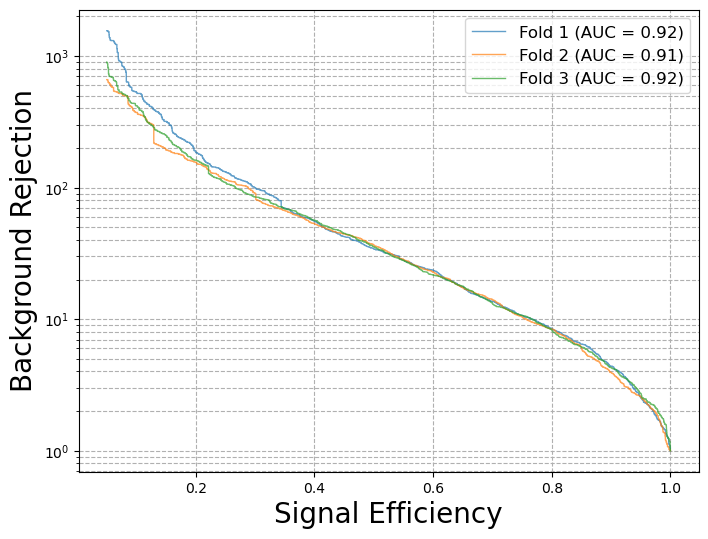

In [76]:
# models = []
signal_scores = []
background_scores = []
signal_weights = []
bkg_weghts = []

bdt_training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']
feature_name_mapping = {
    'leadsubjet_pt': 'f0',
    'subleadsubjet_pt': 'f1',
    'visible_ditau_m': 'f2',
    'collinear_mass': 'f3',
    'delta_R': 'f4',
    'met': 'f5',
    'met_sig': 'f6',
    'x1': 'f7',
    'x2': 'f8',
    'met_centrality': 'f9',
}

#map df_split cloumn names 
for i in range(len(df_split)):
    df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# print(df_split[0])
plt.figure(figsize=(8, 6))

for i in range(len(df_split)):

    X_test = df_split[i][bdt_training_var]
    y_test = df_split[i]['label']
    evnt_w_test = df_split[i]['combined_weights']
    ff_test = df_split[i]['fake_factor']

    X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[bdt_training_var]
    y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']
    evnt_w_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['combined_weights']
    ff_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['fake_factor']

    # training_weight = ff_train*evnt_w_train
    # val_weights = ff_test*evnt_w_test

    training_weight = evnt_w_train
    val_weights = evnt_w_test

    # training_weight = np.ones(len(y_train))
    # val_weights = np.ones(len(y_test))

    # training_weight = training_weight / np.mean(training_weight)
    # val_weights = val_weights / np.mean(val_weights)

    print("len X_train:", len(X_train))
    print("len X_test:", len(X_test))

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    print("signal scaling factor: ", scale_pos_weight)
    
    params = {
    'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'objective':'binary:logistic', 
    'gamma': 0.001,
    'verbosity': 1
    }

    model = XGBClassifier(**params)
    # Train the model
    model.fit(X_train, y_train, sample_weight=training_weight)
    # models.append(model)
    booster = model.get_booster()
    booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)
    # Extract scores for signal and background
    signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
    background_scores.extend(y_pred_proba[:, 1][y_test == 0])

    #add scores to df panda frame
    # df_split[i]['mva_scores'] = y_pred_proba[:, 1]

    signal_weights.extend(ff_test[y_test == 1]*-1/ff_scale)
    bkg_weghts.extend(ff_test[y_test == 0]*-1/ff_scale)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], sample_weight=val_weights)
    fpr = fpr[tpr > 0.05]
    tpr = tpr[tpr > 0.05]
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
plt.xlabel('Signal Efficiency', fontsize=20)
plt.ylabel('Background Rejection', fontsize=20)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()



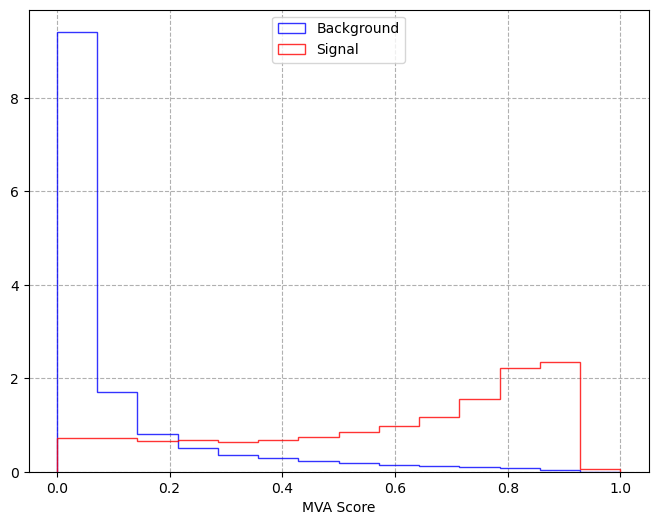

In [77]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='blue', label='Background', histtype='step', density=True)
plt.hist(signal_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='red', label='Signal', histtype='step', density=True)
plt.xlabel('MVA Score')
# plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True, which="both", ls="--")
plt.show()

In [72]:
# sig_hist = plt_to_root_hist_w(signal_scores, 15, 0., 1., None, False)
# bkg_hist = plt_to_root_hist_w(background_scores, 15, 0., 1., None, False)
# sig_hist.Scale(1/sig_hist.Integral())
# bkg_hist.Scale(1/bkg_hist.Integral())
# significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False)